In [1]:
import bz2
import pandas as pd
import numpy as np
import re
import string
import nltk

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Download necessary nltk resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def load_data(file_path):
    data = []
    with bz2.BZ2File(file_path, 'r') as bzfile:
        for line in bzfile:
            line = line.decode('utf-8').strip()
            label = 1 if line.startswith('__label__2') else 0  # Assuming __label__2 is positive, others are negative
            text = line[11:] #remove label from the text
            data.append((text, label))
    return data

In [5]:
train_data_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'
test_data_path = '/kaggle/input/amazonreviews/test.ft.txt.bz2'

In [6]:
# Load data
train_data_list = load_data(train_data_path)
test_data_list = load_data(test_data_path)

In [7]:
# Convert to Pandas DataFrame for easy analysis
train_df = pd.DataFrame(train_data_list, columns=['text', 'label'])
test_df = pd.DataFrame(test_data_list, columns=['text', 'label'])

In [8]:
# Display information about the datasets
print("Train DataFrame:")
print(train_df.head())
print(train_df.info())
print(train_df['label'].value_counts())

print("\nTest DataFrame:")
print(test_df.head())
print(test_df.info())
print(test_df['label'].value_counts())

Train DataFrame:
                                                text  label
0  Stuning even for the non-gamer: This sound tra...      1
1  The best soundtrack ever to anything.: I'm rea...      1
2  Amazing!: This soundtrack is my favorite music...      1
3  Excellent Soundtrack: I truly like this soundt...      1
4  Remember, Pull Your Jaw Off The Floor After He...      1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
 1   label   int64 
dtypes: int64(1), object(1)
memory usage: 54.9+ MB
None
label
1    1800000
0    1800000
Name: count, dtype: int64

Test DataFrame:
                                                text  label
0  Great CD: My lovely Pat has one of the GREAT v...      1
1  One of the best game music soundtracks - for a...      1
2  Batteries died within a year ...: I bought thi...      0
3  works fine, but Maha Energy is better: Check o...      1


In [9]:
# Define preprocessing functions
def preprocess_text(text):
    text = text.lower() # Lowercase the text
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    tokens = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words] # Remove stopwords
    return tokens

# Apply the preprocessing to the text
train_df['tokens'] = train_df['text'].apply(preprocess_text)
test_df['tokens'] = test_df['text'].apply(preprocess_text)

In [10]:
# Build vocabulary and create mapping from tokens to indices
def build_vocabulary(tokenized_texts, max_vocab_size = 10000):
    all_tokens = [token for tokens in tokenized_texts for token in tokens] #flatten list of tokens
    token_counts = Counter(all_tokens)
    most_common_tokens = [token for token, count in token_counts.most_common(max_vocab_size - 1)] # -1 to leave room for the UNKNOWN token
    word_to_index = {token: index+1 for index, token in enumerate(most_common_tokens)} # index 0 will be unknown
    word_to_index['<UNK>'] = 0
    return word_to_index


word_to_index = build_vocabulary(train_df['tokens'], max_vocab_size = 10000)
vocab_size = len(word_to_index)
print("Vocabulary size:", vocab_size)


Vocabulary size: 10000


In [11]:
def tokens_to_indices(tokens, word_to_index):
    return [word_to_index.get(token, 0) for token in tokens]

# Convert tokens to indices
train_df['indexed_tokens'] = train_df['tokens'].apply(lambda tokens: tokens_to_indices(tokens, word_to_index))
test_df['indexed_tokens'] = test_df['tokens'].apply(lambda tokens: tokens_to_indices(tokens, word_to_index))

In [12]:
# Split train data into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(train_df['indexed_tokens'].tolist(), train_df['label'].tolist(), test_size=0.2, random_state = 42)

In [13]:
# Extract test data
test_texts = test_df['indexed_tokens'].tolist()
test_labels = test_df['label'].tolist()

In [14]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)


In [15]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.stack(labels).unsqueeze(1)
    return padded_texts, labels

In [16]:
# Create data loaders
batch_size = 32
train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)
test_dataset = TextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [17]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid() # For Binary classification


    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        output = self.fc(hidden[-1,:,:]) # Using the hidden from the last layer
        return self.sigmoid(output) # Apply sigmoid for final output




In [18]:
# Hyperparameters
embedding_dim = 100
hidden_dim = 128
output_dim = 1  # Binary classification (positive/negative)
learning_rate = 0.001
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Use gpu if available

# Initialize Model
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
def train_loop(model, dataloader, optimizer, criterion, device):
  model.train()
  epoch_loss = 0
  for texts, labels in dataloader:
        optimizer.zero_grad()
        texts = texts.to(device)
        labels = labels.to(device)
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

  return epoch_loss / len(dataloader)

In [20]:
def evaluate_loop(model, dataloader, criterion, device):
  model.eval()
  epoch_loss = 0
  all_predictions = []
  all_labels = []
  with torch.no_grad():
    for texts, labels in dataloader:
        texts = texts.to(device)
        labels = labels.to(device)
        predictions = model(texts)
        loss = criterion(predictions, labels)
        epoch_loss += loss.item()

        all_predictions.extend(predictions.squeeze().cpu().numpy().tolist())
        all_labels.extend(labels.squeeze().cpu().numpy().tolist())
  
  threshold = 0.5
  predicted_labels = [1 if pred >= threshold else 0 for pred in all_predictions]

  accuracy = accuracy_score(all_labels, predicted_labels)
  precision = precision_score(all_labels, predicted_labels)
  recall = recall_score(all_labels, predicted_labels)
  f1 = f1_score(all_labels, predicted_labels)
  cm = confusion_matrix(all_labels, predicted_labels)

  return epoch_loss / len(dataloader), accuracy, precision, recall, f1, cm



In [21]:
for epoch in range(num_epochs):
  train_loss = train_loop(model, train_loader, optimizer, criterion, device)
  val_loss, val_accuracy, val_precision, val_recall, val_f1, val_cm  = evaluate_loop(model, val_loader, criterion, device)
  print(f'Epoch {epoch+1}/{num_epochs}:')
  print(f'\tTrain Loss: {train_loss:.4f}')
  print(f'\tVal Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}')
  print(f'\tValidation Confusion Matrix:\n{val_cm}')
  print('-'*40)


Epoch 1/5:
	Train Loss: 0.2263
	Val Loss: 0.2002 | Val Acc: 0.9200 | Val Precision: 0.9150 | Val Recall: 0.9262 | Val F1: 0.9205
	Validation Confusion Matrix:
[[328753  31006]
 [ 26600 333641]]
----------------------------------------
Epoch 2/5:
	Train Loss: 0.1929
	Val Loss: 0.1952 | Val Acc: 0.9223 | Val Precision: 0.9234 | Val Recall: 0.9211 | Val F1: 0.9222
	Validation Confusion Matrix:
[[332234  27525]
 [ 28439 331802]]
----------------------------------------
Epoch 3/5:
	Train Loss: 0.1837
	Val Loss: 0.1931 | Val Acc: 0.9231 | Val Precision: 0.9239 | Val Recall: 0.9222 | Val F1: 0.9230
	Validation Confusion Matrix:
[[332400  27359]
 [ 28043 332198]]
----------------------------------------
Epoch 4/5:
	Train Loss: 0.1781
	Val Loss: 0.1925 | Val Acc: 0.9236 | Val Precision: 0.9267 | Val Recall: 0.9201 | Val F1: 0.9234
	Validation Confusion Matrix:
[[333545  26214]
 [ 28785 331456]]
----------------------------------------
Epoch 5/5:
	Train Loss: 0.1744
	Val Loss: 0.1925 | Val Acc: 

Test Loss: 0.1945 | Test Acc: 0.9224 | Test Precision: 0.9205 | Test Recall: 0.9247 | Test F1: 0.9226

Test Confusion Matrix:
[[184021  15979]
 [ 15052 184948]]


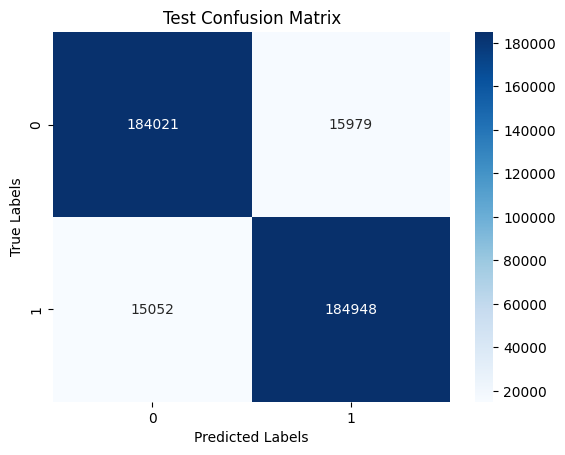

In [22]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_loop(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f} | Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}')
print(f'\nTest Confusion Matrix:\n{test_cm}')
sns.heatmap(test_cm, annot = True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title('Test Confusion Matrix')
plt.show()